# Music genre classification

Este Jupyter notebook tem como objetivo apresentar a inteligência desenvolvida para realizar a predição do gênero musical a partir de sua letra, tendo como referência um _dataset_ disponibilizado com amostras dos seguintes gêneros:
- Bossa Nova
- Funk
- Gospel
- Sertanejo

Sendo assim, o alvo da predição será um dos gêneros acima.

## EDA (_Exploratory data analysis_)

### Carregando os dados

Os arquivos estão separados em 4 arquivos distintos, onde cada arquivo contém letras de um mesmo gênero. A seguir, os dados serão carregados para um `Pandas Dataframe`.

In [1]:
import pandas as pd
import os

In [2]:
DATA_DIR = "../data/lyrics/"
FILE_BASE = "{}.csv"

In [3]:
genres = ["bossa_nova", "funk", "gospel", "sertanejo"]

Com a operação abaixo, os dados serão carregados e um rótulo será adicionado a eles, o qual será usad futuramente como _target_ do _Machine Learning_ a ser aplicado.

In [4]:
def load_lyrics(name):
    df = pd.read_csv(os.path.join(DATA_DIR, FILE_BASE.format(name)), encoding='utf-8')
    df["genre"] = name
    return df

In [5]:
genres_dfs = []
for genre in genres:
    genres_dfs.append(load_lyrics(genre))

In [6]:
df = pd.concat(genres_dfs)

In [7]:
df.head()

,lyric,genre
0,\nEu sei que vou te amar\nPor toda a minha vi...,bossa_nova
1,\nOlha que coisa mais linda\nMais cheia de gr...,bossa_nova
2,\nEra uma casa\nMuito engraçada\nNão tinha te...,bossa_nova
3,"\nDe tudo, ao meu amor serei atento antes\nE ...",bossa_nova
4,\nQuando a luz dos olhos meus\nE a luz dos ol...,bossa_nova


In [8]:
df.shape

(3200, 2)

Ao final do carregamento, temos 3200 entradas com as propriedades `lyric` (letra propriamente dita) e `genre` (gênero musical originalmente atribuído na fonte de dados).

### Data quality

#### Remoção de valores nulos ou `None`

In [9]:
df = df[df["lyric"] != "None"].dropna()

In [10]:
df.shape[0]

3198

Foram encontrados duas entradas com valor `None` para a propriedade `Lyric`, o que deixará o _dataset_ com 3198 entradas.

#### Detecção de idioma

Após uma inspeção visual nos dados, foram identificadas várias entradas nas quais o idioma das letras não eram português. Sendo assim, é necessário medir o impacto disso dentro de todo o domínio de dados.

In [11]:
from langdetect import detect

In [12]:
df["language"] = df["lyric"].apply(lambda x: detect(x))

In [13]:
languages = df["language"].unique()

In [14]:
print len(languages)

10


In [15]:
for lang in languages: print lang

pt
fr
en
it
es
sw
ca
tl
lt
ro


In [16]:
from __future__ import division

for genre in genres:
    print genre, (df[(df["genre"] == genre) & (df["language"] != "pt")].shape[0] / df[(df["genre"] == genre)].shape[0]) * 100

bossa_nova 10.5
funk 0.75
gospel 0.877192982456
sertanejo 0.0


In [17]:
print "General non pt lyric ratio: ", (df[df["language"] != "pt"].shape[0] / df.shape[0]) * 100

General non pt lyric ratio:  3.03314571607


As informações acima mostram que 10,5% das letras das músicas de Bossa Nova são de idiomas diferentes do Português (sem avaliar a precisão da metodoliga de tradução). Entretanto, para as outras classes a taxa é de aproximadamente 1%, resultado em uma taxa geral de 3%.

Por conta do propósito desta análise e da natureza da inteligência que virá a seguir, que será bastante inerente ao _corpus_ do idioma principal, e por algumas análises posteriores do impacto de uma _feature_ relacionada ao idioma, será considerado daqui adiante apenas as letras com o idioma Português.

##### Como poderia ser tratada a questão de idioma?

Para a questão de idioma, uma vez que é conhecido a base linguística de cada letra de música, uma estratégia seria tratar de maneira dinâmica o processo de tratamento de texto. A seguir será executado um processo dinâmico como exemplo, porém que não será usado na etapa de classificação.

Na sequência serão realizados os seguintes processos sobre o domínio de dados:

- _Stemming_, onde serão extraídos apenas os radicais que compôem as palavras;
- Remoção de _stop words_, palavras como artigos, preposições e conjunções que servem para conectar as palavras principais. Como não será tratada a semântica das letras, não será útil;
- Remoção de pontuação.

In [18]:
import nltk
import string
import re

from nltk.tokenize import RegexpTokenizer

In [19]:
nltk.download('rslp')
nltk.download('stopwords')

[nltk_data] Downloading package rslp to
[nltk_data]     /home/wespatrocinio/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/wespatrocinio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
STEM_MAP = {
    "pt": nltk.stem.RSLPStemmer(),
    "en": nltk.stem.snowball.EnglishStemmer(),
    "fr": nltk.stem.snowball.FrenchStemmer(),
    "es": nltk.stem.snowball.SpanishStemmer(),
    "it": nltk.stem.snowball.ItalianStemmer()
}

In [21]:
LANGUAGE_MAP = {
    "pt": "portuguese",
    "en": "english",
    "fr": "french",
    "it": "italian",
    "es": "spanish"
}

O método abaixo trata de maneira automática a seleção de _stemmers_ e _stop words_ de acordo com o idioma da letra.

In [22]:
def tokenizer(row):
    lower_case = row["lyric"].lower()
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(lower_case)
    stemmer = STEM_MAP.get(row["language"]) if STEM_MAP.get(row["language"]) else STEM_MAP.get("pt")
    stems = [stemmer.stem(t) for t in tokens]
    language_full = LANGUAGE_MAP.get(row["language"])
    if language_full:
        stopwords = nltk.corpus.stopwords.words(language_full)
    else:
        stopwords = nltk.corpus.stopwords.words("portuguese")
    return [token for token in stems if token not in stopwords]

In [23]:
df["tokens"] = df.apply(lambda row: tokenizer(row), axis=1)

In [24]:
df.head()

,lyric,genre,language,tokens
0,\nEu sei que vou te amar\nPor toda a minha vi...,bossa_nova,pt,"[sei, vou, am, tod, minh, vid, vou, am, cad, d..."
1,\nOlha que coisa mais linda\nMais cheia de gr...,bossa_nova,pt,"[olh, cois, lind, chei, graç, é, menin, vem, p..."
2,\nEra uma casa\nMuito engraçada\nNão tinha te...,bossa_nova,pt,"[cas, muit, engraç, tinh, tet, tinh, nad, ning..."
3,"\nDe tudo, ao meu amor serei atento antes\nE ...",bossa_nova,pt,"[tud, am, ser, atent, ant, tal, zel, sempr, ta..."
4,\nQuando a luz dos olhos meus\nE a luz dos ol...,bossa_nova,pt,"[qu, luz, olh, luz, olh, resolv, encontr, ai, ..."


#### Remoção de _outliers_

Letras de música possuem diversos tamanhos, seja pela dimensão temporal da música quanto pela estrtura da composição. Por conta disso, será realizada uma breve análise com relação ao tamanho da letra com base nos _tokens_ obtidos acima, partir de duas métricas:
- `num_tokens`, ou seja, a quantidade total de _tokens_ de uma letra;
- `num_distinct_tokens`, ou seja, a quantidade de _tokens_ distintos (sem repetição);

In [25]:
df["num_tokens"] = df["tokens"].apply(lambda x: len(x))

In [26]:
df["num_distinct_tokens"] = df["tokens"].apply(lambda x: len(set(x)))

Alguns gráficos serão plotados para melhor visualização do cenário.

In [28]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')

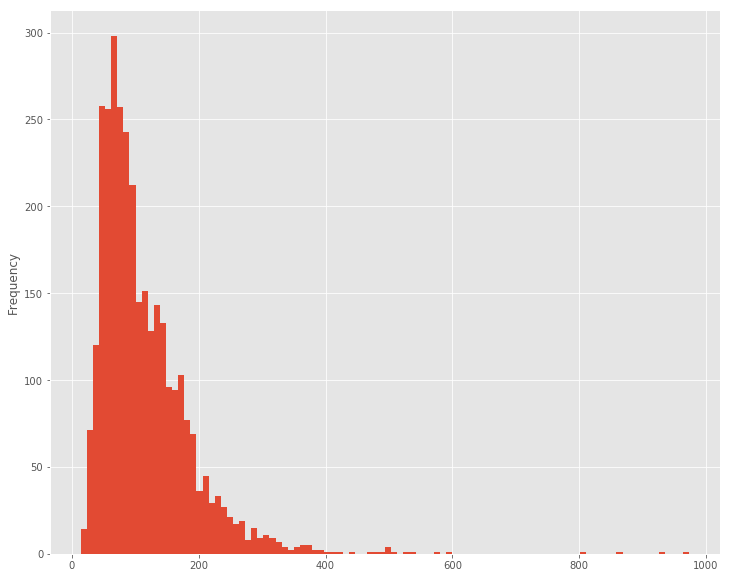

In [33]:
df["num_tokens"].plot.hist(figsize=(12,10), bins=100)

É possível observar uma cauda bastante longa no limite superior de `num_tokens`. Por conta disso, será considerado o percentil 99% do _dataset_, para evitar problemas na classificação como o _overfitting_.

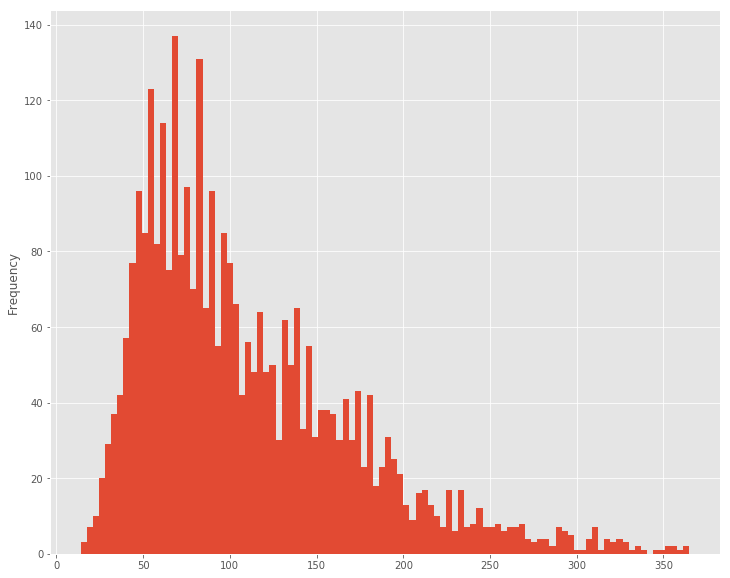

In [38]:
df[df["num_tokens"] <= df["num_tokens"].quantile(0.99)]["num_tokens"].plot.hist(figsize=(12,10), bins=100)

In [40]:
NUM_TOKENS_THRESHOLD = df["num_tokens"].quantile(0.99)

O valor abaixo será usado como linha de corte para o _dataset_ de treinamento / validação.

In [41]:
print NUM_TOKENS_THRESHOLD

365.0


O processo realizado para `num_tokens` será aplicado em `num_distinct_tokens`.

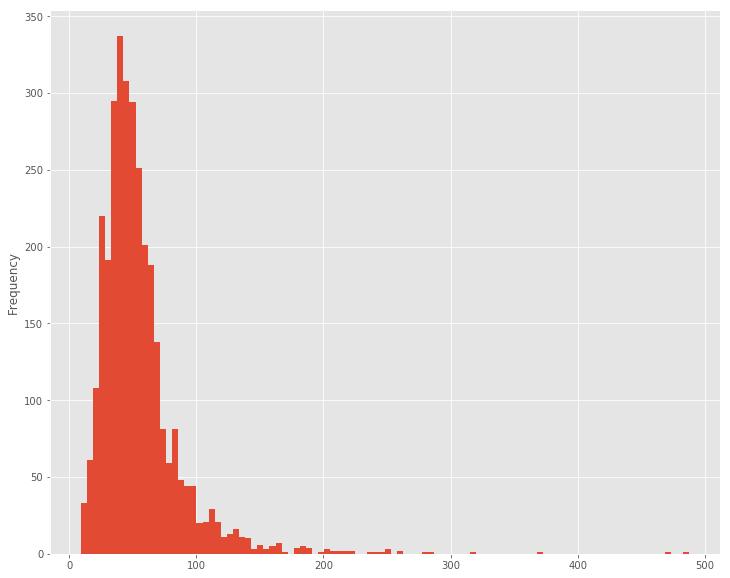

In [42]:
df["num_distinct_tokens"].plot.hist(figsize=(12,10), bins=100)

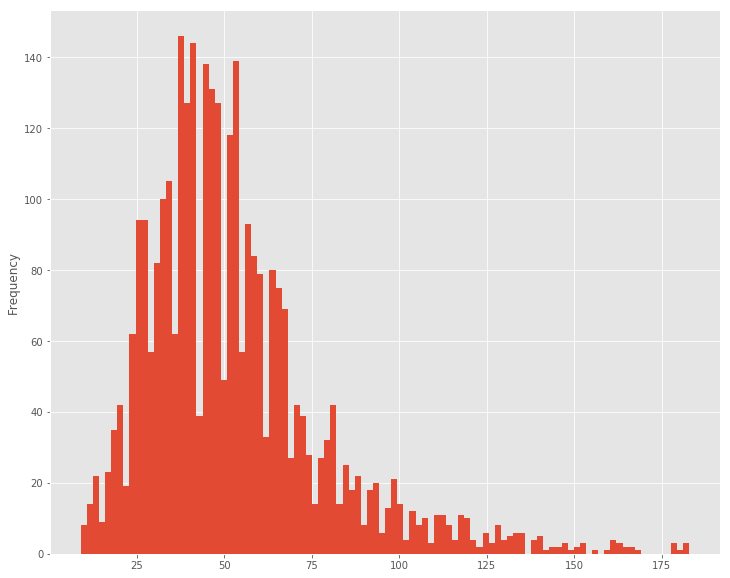

In [43]:
df[df["num_distinct_tokens"] <= df["num_distinct_tokens"].quantile(0.99)]["num_distinct_tokens"].plot.hist(figsize=(12,10), bins=100)

In [64]:
ratios = []
for genre in genres:
    ratios.append(["num_tokens", "mean", genre, df[df["genre"] == genre]["num_tokens"].mean()])
    ratios.append(["num_distinct_tokens", "mean", genre, df[df["genre"] == genre]["num_distinct_tokens"].mean()])
    ratios.append([
        "distinct / all",
        "ratio",
        genre,
        (df[df["genre"] == genre]["num_distinct_tokens"].mean() / df[df["genre"] == genre]["num_tokens"].mean()) * 100
    ])

In [62]:
df_ratios = pd.DataFrame(ratios, columns=["metric", "stat", "genre", "value"])

In [63]:
df_ratios

,metric,stat,genre,value
0,num_tokens,mean,bossa_nova,85.252500
1,num_distinct_tokens,mean,bossa_nova,50.116250
2,distinct / all,ratio,bossa_nova,58.785666
3,num_tokens,mean,funk,157.728750
4,num_distinct_tokens,mean,funk,64.511250
5,distinct / all,ratio,funk,40.900121
6,num_tokens,mean,gospel,108.411028
7,num_distinct_tokens,mean,gospel,50.957393
8,distinct / all,ratio,gospel,47.003884
9,num_tokens,mean,sertanejo,106.092500


Como podemos ver na tabela acima, a taxa de _tokens_ duplicados (medida pela razão `distinct / all`) varia bastante entre os gêneros. Por exemplo, `bossa_nova` tem ~59% de tokens únicos enquanto `funk` tem ~41%, ou seja, há uma repetição de palavras no gênero `funk` consideravelmente maior. Esta informação nos será útil mais abaixo, para a escolha da estratégia de _feature engineering_ a ser usada.

#### _Dataset_ que será usado na fase de _Machine Learning_

No _dataset_ final, filtraremos os _outliers_ de quantidade de tokens (mantendo percentil 98%) e também as letras que não estão em português.

In [65]:
df_clean = df[(df["num_tokens"] <= NUM_TOKENS_THRESHOLD) & (df["language"] == "pt")]

In [66]:
df_clean.shape[0]

3070

In [68]:
df.shape[0] - df_clean.shape[0]

128

In [69]:
print ((df.shape[0] - df_clean.shape[0]) / df.shape[0]) * 100

4.00250156348


Foram descartadas 128 entradas (4%), a partir da limpeza de valores nulos que já havia sido feita.

## Classificação

O problema estabelecido é a previsão do gênero musical a partir de uma letra, com base em nosso domínio de dados _grounfd truth_. Sendo assim, temos um problema claro e explítico de uma classificação multi-classes (4 no total).

Para resolver tal problema, temos então as seguintes etapas:
- Engenharia de _features_, onde representaremos os dados brutos em _features_ sobre as quais o classificador realizará o trabalho de aprendizado e classificação propriamente dita;
- Classificação propriamente dita, etapa onde um ou mais algoritimos de _Machine Learning_ serão aplicados para tentar realizar a melhor predição possível;

Lembrando que a métrica escolhida para a avaliação do classificador será a Acurácia.

### Engenharia de features

Agora que temos uma visão melhor dos dados e do problema a ser resolvido, podemos partir para a etapa onde extrairemos os atributos (_features_) que serão utilizadas para o treinamento e validação dos algoritmos de _Machine Learning_.

Reforçando aqui que:
- Fizemos o _drop_ de valores nulos;
- Removemos _outliers_ com relação à quantidade de _tokens_ em uma mesma música (pegamos o percentil 99);
- Desprezamos as letras com idiomas diferentes de Português. Mesmo que o grupo `bossa_nova` tivesse uma taxa consideravelmente maior que os demais, tal taxa não era tão relevante e poderia nos levar a uma condição de _overfit_, uma vez que não temos fatos que mostrem que a taxa de músicas em outras línguas, como um todo, tem a mesma distribuição que o _dataset_ de treinamento;

#### TF-IDF

Para este problema em específico, a estratégia escolhida foi o uso do índice de TF-IDF (_Term frequency_-_Inverse document frequecy_). Esta estratégia foi escolhida pelos seguintes motivos:
- Como o objetivo é classificar uma letra de música em uma categoria, a combinação de um conjunto de tokens em um mesmo documento parece ser o suficiente para classificar, ao invés de extrair tópicos ou semântica deste documento (o que poderia nos levar a outra classe de algoritmos como LDA, _word2vec_, etc);
- O EDA realizado acima mostrou que a frequência/taxa de repetição de _tokens_ entre os _genres_ podem diferir bastante. Sendo assim, o _term frequency_ (TF) tende a ser relevante. Casos estivéssemos trabalhando com documentos pequenos ou sem relevância de repetição de _tokens_, apenas o IDF seria suficiente;
- Pela praticidade em usar as ferramentas prontas do Scikit-learn ;)

Dessa forma, teremos como nosso _dataset_ de dados para a etapa de classificação:
- _Features_ (X): as letras de música, que posteriormente serão transformadas em vetores de TF-IDF;
- _Target_ (y): as categorias de cada música, obtidas do _dataset_ usado como _ground truth_;

In [89]:
X = df_clean["lyric"]
y = df_clean["genre"]

Vamos separar o _dataset_ em duas partes: uma para treinamento do algoritmo e outra para validação da performance do mesmo (30% dos dados).

In [90]:
from sklearn.cross_validation import train_test_split

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [92]:
X_train.to_csv("../data/features/X_train.csv", sep=";", encoding='utf-8')
y_train.to_csv("../data/features/y_train.csv", sep=";", encoding='utf-8')
X_test.to_csv("../data/features/X_test.csv", sep=";", encoding='utf-8')
y_test.to_csv("../data/features/y_test.csv", sep=";", encoding='utf-8')

A partir de agora vamos transformar as nossas _features_ brutas em seu formato final.

Vamos então extrair os _tokens_ dos textos brutos realizando os seguintes processos sobre os dados:
- _Stemming_ específico para Português;
- Todas as letras em minúsculo;
- Remoção de pontuação;
- Remoção de _stop words_;

In [78]:
def text_tokenizer(text):
    stemmer = nltk.stem.RSLPStemmer()
    lower_case = text.lower()
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(lower_case)
    return [stemmer.stem(t) for t in tokens]

Criaremos um espaço vetorial onde cada token único de nosso _bag of words_ é uma componente, e para cada amostra criaremos a representação neste espaço, ou seja, o coeficiente de cada componente será o _score_ de TF-IDF do token naquele documento.

In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
            encoding='utf-8',
            decode_error='replace',
            strip_accents='unicode',
            analyzer='word',
            binary=False,
            stop_words=nltk.corpus.stopwords.words("portuguese"),
            tokenizer=text_tokenizer
    )

In [80]:
tfidf.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='replace',
        dtype=<type 'numpy.int64'>, encoding='utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words=[u'de', u'a', u'o', u'que', u'e', u'do', u'da', u'em', u'um', u'para', u'com', u'n\xe3o', u'uma', u'os', u'no', u'se', u'na', u'por', u'mais', u'as', u'dos', u'como', u'mas', u'ao', u'ele', u'das', u'\xe0', u'seu', u'sua', u'ou', u'quando', u'muito', u'nos', u'j\xe1', u'eu', u'tamb\xe9m',...os', u'tiverem', u'terei', u'ter\xe1', u'teremos', u'ter\xe3o', u'teria', u'ter\xedamos', u'teriam'],
        strip_accents='unicode', sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=<function text_tokenizer at 0x7f2c38cd87d0>,
        use_idf=True, vocabulary=None)

Vamos salvar este _vectorizer_ pois precisaremos dele na construção da API que fará a classificação de gênero musical. 

In [83]:
import pickle

with open('../model/vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

Agora transformaremos nossa _feature_ bruta no vetor de TF-IDF

In [84]:
X_train = pd.DataFrame(tfidf.transform(X_train).toarray())

In [85]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7961,7962,7963,7964,7965,7966,7967,7968,7969,7970
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Como podemos ver acima, temos como _features_ as componentes do vetor de cada amostra representado no espaço vetorial de _tokens_ de nossa _bag of words_.

Vamos transformar o _dataset_ de treinamento para o **mesmo espaço vetorial do treinamento**. Este detalhe é muito importante, pois precisamos comparar banana com banana, ou seja, precisamos comparar as amostras dentro do mesmo espaço vetorial.

In [86]:
X_test = pd.DataFrame(tfidf.transform(X_test).toarray())

In [87]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7961,7962,7963,7964,7965,7966,7967,7968,7969,7970
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
print X_test.shape[1], X_train.shape[1]

7971 7971


Ambos os conjuntos de dados tem o mesmo número de _features_.

### _Machine learning_

Nesta etapa, aplicaremos alguns algoritmos de _Machine Learning_ sobre os dados de treino e avaliação acima visando a construção de um modelo que seja capaz de classificar o gênero de uma música a partir de sua letra.

Para tal, serão utilizados dois algoritmos para classificação:
- _Random Forest_;
- _Logistic regression_;

##### Random Forest

In [65]:
from sklearn.ensemble import RandomForestClassifier

In [66]:
clf = RandomForestClassifier(n_estimators=200)

In [67]:
clf = clf.fit(X_train, y_train)

In [69]:
from sklearn import metrics
from sklearn.metrics import accuracy_score

In [70]:
y_pred = clf.predict(X_test)

In [71]:
metrics.confusion_matrix(y_test, y_pred)

array([[160,  14,  21,  29],
       [  4, 186,   6,  27],
       [  2,   1, 209,  12],
       [ 16,  16,  18, 190]])

In [72]:
print metrics.classification_report(y_test, y_pred)

             precision    recall  f1-score   support

 bossa_nova       0.88      0.71      0.79       224
       funk       0.86      0.83      0.85       223
     gospel       0.82      0.93      0.87       224
  sertanejo       0.74      0.79      0.76       240

avg / total       0.82      0.82      0.82       911



In [73]:
accuracy_score(y_test, y_pred)

0.81778265642151482

##### Naive Bayes (Gaussian)

In [74]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [75]:
y_nb_pred = nb.predict(X_test)

In [76]:
metrics.confusion_matrix(y_test, y_nb_pred)

array([[115,  33,  25,  51],
       [  5, 194,   3,  21],
       [  7,  13, 190,  14],
       [ 15,  51,  43, 131]])

In [77]:
print metrics.classification_report(y_test, y_nb_pred)

             precision    recall  f1-score   support

 bossa_nova       0.81      0.51      0.63       224
       funk       0.67      0.87      0.75       223
     gospel       0.73      0.85      0.78       224
  sertanejo       0.60      0.55      0.57       240

avg / total       0.70      0.69      0.68       911



In [78]:
accuracy_score(y_test, y_nb_pred)

0.69154774972557631

##### SVM

In [80]:
from sklearn.svm import SVC

In [94]:
svc = SVC(gamma=2, C=1)
svc.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=2, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [95]:
y_svc_pred = svc.predict(X_test)

In [96]:
metrics.confusion_matrix(y_test, y_svc_pred)

array([[160,  22,   7,  35],
       [  3, 189,   6,  25],
       [  3,   2, 208,  11],
       [ 14,  15,  16, 195]])

In [97]:
print metrics.classification_report(y_test, y_svc_pred)

             precision    recall  f1-score   support

 bossa_nova       0.89      0.71      0.79       224
       funk       0.83      0.85      0.84       223
     gospel       0.88      0.93      0.90       224
  sertanejo       0.73      0.81      0.77       240

avg / total       0.83      0.83      0.82       911



In [98]:
accuracy_score(y_test, y_svc_pred)

0.82546652030735457

##### Linear Regression

In [99]:
from sklearn.linear_model import LogisticRegression

In [162]:
lr = LogisticRegression(
    solver='lbfgs',
    multi_class="multinomial",
    C=2,
    penalty='l2',
    fit_intercept=False,
    max_iter=5,
    random_state=42,
)
lr.fit(X_train, y_train)

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=5, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [163]:
y_lr_pred = lr.predict(X_test)

In [164]:
metrics.confusion_matrix(y_test, y_lr_pred)

array([[182,   9,   8,  25],
       [  6, 192,   5,  20],
       [  3,   0, 212,   9],
       [ 23,   9,  19, 189]])

In [165]:
print metrics.classification_report(y_test, y_lr_pred)

             precision    recall  f1-score   support

 bossa_nova       0.85      0.81      0.83       224
       funk       0.91      0.86      0.89       223
     gospel       0.87      0.95      0.91       224
  sertanejo       0.78      0.79      0.78       240

avg / total       0.85      0.85      0.85       911



In [166]:
accuracy_score(y_test, y_lr_pred)

0.85071350164654225

### Tunning

In [242]:
from sklearn.grid_search import GridSearchCV
from scipy.stats import randint as sp_randint

In [285]:
param_grid = {
    "max_depth": [3, 10, 20, 50],
    "min_samples_split": [5, 20, 50],
    "min_samples_leaf": [5, 10, 20],
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"],
    "n_estimators": [50, 100, 200]
}

In [286]:
seed_clf = RandomForestClassifier()

In [287]:
grid_search = GridSearchCV(seed_clf, param_grid=param_grid)

In [328]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'bootstrap': [True, False], 'min_samples_leaf': [5, 10, 20], 'n_estimators': [50, 100, 200], 'criterion': ['gini', 'entropy'], 'min_samples_split': [5, 20, 50], 'max_depth': [3, 10, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [329]:
best_clf = grid_search.best_estimator_

In [330]:
best_clf

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=5, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [331]:
y_best_pred = best_clf.predict(X_test)

In [332]:
metrics.confusion_matrix(y_test, y_best_pred)

array([[159,  15,  17,  32],
       [  3, 179,   9,  35],
       [  3,   0, 216,   9],
       [ 16,   9,  20, 189]])

In [333]:
print metrics.classification_report(y_test, y_best_pred)

             precision    recall  f1-score   support

 bossa_nova       0.88      0.71      0.79       223
       funk       0.88      0.79      0.83       226
     gospel       0.82      0.95      0.88       228
  sertanejo       0.71      0.81      0.76       234

avg / total       0.82      0.82      0.81       911



In [334]:
accuracy_score(y_test, y_best_pred)

0.81558726673984627

## Saving the model

In [ ]:
from sklearn.externals import joblib

In [290]:
import pickle

In [325]:
with open('../model/classifier.pkl', 'wb') as f:
    pickle.dump(clf, f)

In [300]:
# with open('../model/vectorizer.pkl', 'wb') as f:
#     pickle.dump(tfidf, f)